# 第三阶段：数据治理与预处理

## 🎯 Notebook目标
基于前两阶段的发现，本Notebook将执行**系统化的数据治理**。这是整个项目的核心，因为：
> "高质量的数据准备工作决定了模型的上限。模型调优只能让你接近这个上限，但数据质量问题会从根本上限制模型性能。"

### 本阶段的关键问题
**核心问题**：为什么不能直接把原始数据喂给模型？

**答案**：
1. **缺失值**会导致训练失败或产生偏差
2. **异常值**会扭曲模型参数，降低泛化能力
3. **原始特征**可能无法充分表达数据中的模式
4. **数据偏见**会导致模型对某些群体不公平

### 数据治理 vs 数据清洗
很多人混淆这两个概念：

| 数据清洗 | 数据治理 |
|---------|---------|
| 修复错误和不一致 | **战略性地改造数据** |
| 技术操作 | **包含决策和权衡** |
| "让数据能用" | **"让数据能产生价值"** |

本Notebook采用的是**数据治理**的视角，每一步都有明确的理由和权衡考量。

---

## 📊 治理策略总览

我们将创建**三个版本**的数据，用于后续对比实验：

### Version A: Minimal Processing（极简处理）
- **策略**：仅做最基础处理（删除缺失行）
- **目的**：作为基线，展示"不治理"的后果
- **预期**：模型性能可能尚可，但不稳定、不公平

### Version B: Full Governance（完整治理）
- **策略**：系统化的清洗、转换、特征工程
- **目的**：展示专业数据治理的价值
- **预期**：更高的准确率、更好的稳健性

### Version C: Balanced（平衡采样）
- **策略**：在B基础上加入SMOTE平衡采样
- **目的**：缓解类别不平衡，提升公平性
- **预期**：少数类召回率显著提升

这种**对比实验设计**是本作业的核心价值所在！

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
sns.set_style('whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. 数据加载

In [2]:
data_path = '../data/raw/adult.csv'
df_original = pd.read_csv(data_path)

df = df_original.copy()

print(f"Original dataset shape: {df.shape}")
print(f"\nFirst few rows:")
display(df.head())

Original dataset shape: (32561, 15)

First few rows:


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## 2. 缺失值处理

### 2.1 识别缺失值（包括'?'标记）

In [3]:
df = df.replace('?', np.nan)

missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

print("=== Missing Values Summary ===")
display(missing_summary[missing_summary['Missing_Count'] > 0])

cols_with_missing = missing_summary[missing_summary['Missing_Count'] > 0]['Column'].tolist()

=== Missing Values Summary ===


,Column,Missing_Count,Missing_Percentage
occupation,occupation,1843,5.66
workclass,workclass,1836,5.64
native.country,native.country,583,1.79


### 2.2 缺失值处理策略

**策略选择依据：**
- 缺失率 < 5%：直接删除行
- 5% ≤ 缺失率 < 40%：使用众数/中位数填充或预测填充
- 缺失率 ≥ 40%：考虑删除该列或创建"缺失"类别

In [4]:
print("=== Handling Missing Values ===")

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in cols_with_missing:
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    print(f"\nProcessing '{col}' (Missing: {missing_pct:.2f}%)")
    
    if missing_pct < 5:
        print(f"  Strategy: Delete rows (low missing rate)")
        df = df.dropna(subset=[col])
    
    elif col in categorical_cols:
        mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        print(f"  Strategy: Fill with mode '{mode_value}'")
        df[col].fillna(mode_value, inplace=True)
    
    elif col in numerical_cols:
        median_value = df[col].median()
        print(f"  Strategy: Fill with median {median_value:.2f}")
        df[col].fillna(median_value, inplace=True)

print(f"\nDataset shape after handling missing values: {df.shape}")
print(f"Rows removed: {len(df_original) - len(df)}")

=== Handling Missing Values ===

Processing 'occupation' (Missing: 5.66%)
  Strategy: Fill with mode 'Prof-specialty'

Processing 'workclass' (Missing: 5.64%)
  Strategy: Fill with mode 'Private'

Processing 'native.country' (Missing: 1.79%)
  Strategy: Delete rows (low missing rate)

Dataset shape after handling missing values: (31978, 15)
Rows removed: 583


### 2.3 高级缺失值填充（可选）：使用IterativeImputer

对于数值型特征，可以使用多重插补方法，基于其他特征预测缺失值。

In [5]:
print("=== Verifying No Missing Values Remain ===")
remaining_missing = df.isnull().sum().sum()
print(f"Total missing values remaining: {remaining_missing}")

if remaining_missing > 0:
    print("\nWarning: Some missing values still exist!")
    display(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("✓ All missing values handled successfully!")

=== Verifying No Missing Values Remain ===
Total missing values remaining: 3625



workclass     1809
occupation    1816
dtype: int64

## 3. 异常值处理

### 3.1 异常值检测（IQR方法）

In [6]:
def detect_and_handle_outliers(df, column, method='cap', lower_quantile=0.01, upper_quantile=0.99):
    """
    Detect and handle outliers
    method: 'cap' (winsorization) or 'remove'
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
    
    if method == 'cap':
        lower_cap = df[column].quantile(lower_quantile)
        upper_cap = df[column].quantile(upper_quantile)
        df[column] = df[column].clip(lower=lower_cap, upper=upper_cap)
        action = f"Capped to [{lower_cap:.2f}, {upper_cap:.2f}]"
    elif method == 'remove':
        original_len = len(df)
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        action = f"Removed {original_len - len(df)} rows"
    
    return df, outliers_count, action

print("=== Outlier Detection and Handling ===")

numerical_cols_for_outlier = [col for col in numerical_cols if col in df.columns]

outlier_report = []
for col in numerical_cols_for_outlier:
    df, outliers, action = detect_and_handle_outliers(df, col, method='cap')
    outlier_report.append({
        'Column': col,
        'Outliers_Found': outliers,
        'Action': action
    })
    print(f"\n{col}:")
    print(f"  Outliers found: {outliers}")
    print(f"  Action: {action}")

outlier_df = pd.DataFrame(outlier_report)
outlier_df.to_csv('../outputs/03_outlier_handling_report.csv', index=False)
print("\n✓ Outlier handling report saved.")

=== Outlier Detection and Handling ===

age:
  Outliers found: 140
  Action: Capped to [17.00, 74.00]

fnlwgt:
  Outliers found: 961
  Action: Capped to [27153.00, 510072.00]

education.num:
  Outliers found: 1158
  Action: Capped to [3.00, 16.00]

capital.gain:
  Outliers found: 2658
  Action: Capped to [0.00, 15024.00]

capital.loss:
  Outliers found: 1483
  Action: Capped to [0.00, 1980.00]

hours.per.week:
  Outliers found: 8850
  Action: Capped to [8.00, 80.00]

✓ Outlier handling report saved.


### 3.2 异常值处理前后对比

In [7]:
print("=== Data Distribution After Outlier Handling ===")
print(df[numerical_cols_for_outlier].describe())

=== Data Distribution After Outlier Handling ===
                age         fnlwgt  education.num  capital.gain  capital.loss  \
count  31978.000000   31978.000000   31978.000000  31978.000000  31978.000000   
mean      38.525736  188495.780193      10.079461    631.590124     83.310463   
std       13.503042   99883.090700       2.535603   2515.391115    381.939291   
min       17.000000   27153.000000       3.000000      0.000000      0.000000   
25%       28.000000  117620.250000       9.000000      0.000000      0.000000   
50%       37.000000  178312.000000      10.000000      0.000000      0.000000   
75%       48.000000  237379.000000      12.000000      0.000000      0.000000   
max       74.000000  510072.000000      16.000000  15024.000000   1980.000000   

       hours.per.week  
count    31978.000000  
mean        40.370473  
std         11.936979  
min          8.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         80.000000  


## 4. 特征工程

### 4.1 创建新特征

In [8]:
print("=== Feature Engineering ===")

if 'age' in df.columns:
    df['age_squared'] = df['age'] ** 2
    print("✓ Created 'age_squared' feature")

if 'capital.gain' in df.columns and 'capital.loss' in df.columns:
    df['capital_net'] = df['capital.gain'] - df['capital.loss']
    df['has_capital_gain'] = (df['capital.gain'] > 0).astype(int)
    df['has_capital_loss'] = (df['capital.loss'] > 0).astype(int)
    print("✓ Created capital-related features")

if 'hours.per.week' in df.columns:
    df['is_full_time'] = (df['hours.per.week'] >= 35).astype(int)
    print("✓ Created 'is_full_time' feature")

if 'age' in df.columns and 'education.num' in df.columns:
    df['age_education_interaction'] = df['age'] * df['education.num']
    print("✓ Created 'age_education_interaction' feature")

if 'marital.status' in df.columns:
    married_categories = ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']
    df['is_married'] = df['marital.status'].isin(married_categories).astype(int)
    print("✓ Created 'is_married' feature")

print(f"\nDataset shape after feature engineering: {df.shape}")

=== Feature Engineering ===
✓ Created 'age_squared' feature
✓ Created capital-related features
✓ Created 'is_full_time' feature
✓ Created 'age_education_interaction' feature
✓ Created 'is_married' feature

Dataset shape after feature engineering: (31978, 22)


### 4.2 编码类别变量

将类别变量转换为数值形式，为机器学习模型做准备。

In [9]:
print("=== Encoding Categorical Variables ===")

df_encoded = df.copy()

label_encoders = {}
categorical_cols_current = df_encoded.select_dtypes(include=['object']).columns.tolist()

target_col = 'income'
if target_col in categorical_cols_current:
    categorical_cols_current.remove(target_col)

for col in categorical_cols_current:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"✓ Encoded '{col}' ({len(le.classes_)} unique values)")

if target_col in df_encoded.columns:
    le_target = LabelEncoder()
    df_encoded[target_col] = le_target.fit_transform(df_encoded[target_col])
    label_encoders[target_col] = le_target
    print(f"\n✓ Encoded target variable '{target_col}'")
    print(f"  Mapping: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

print(f"\nDataset shape: {df_encoded.shape}")
print(f"All columns are now numerical: {df_encoded.select_dtypes(include=['object']).shape[1] == 0}")

=== Encoding Categorical Variables ===
✓ Encoded 'workclass' (9 unique values)
✓ Encoded 'education' (16 unique values)
✓ Encoded 'marital.status' (7 unique values)
✓ Encoded 'occupation' (15 unique values)
✓ Encoded 'relationship' (6 unique values)
✓ Encoded 'race' (5 unique values)
✓ Encoded 'sex' (2 unique values)
✓ Encoded 'native.country' (41 unique values)

✓ Encoded target variable 'income'
  Mapping: {'<=50K': np.int64(0), '>50K': np.int64(1)}

Dataset shape: (31978, 22)
All columns are now numerical: True


## 5. 数据标准化

对数值特征进行标准化（Z-score normalization），使其均值为0，标准差为1。

In [10]:
print("=== Feature Standardization ===")

features_to_scale = df_encoded.columns.drop(target_col if target_col in df_encoded.columns else [])

scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

print("✓ Features standardized (mean=0, std=1)")
print("\nScaled feature statistics:")
print(df_scaled[features_to_scale].describe().loc[['mean', 'std']].round(3))

=== Feature Standardization ===
✓ Features standardized (mean=0, std=1)

Scaled feature statistics:
      age  workclass  fnlwgt  education  education.num  marital.status  \
mean  0.0       -0.0     0.0        0.0           -0.0             0.0   
std   1.0        1.0     1.0        1.0            1.0             1.0   

      occupation  relationship  race  sex  ...  capital.loss  hours.per.week  \
mean         0.0          -0.0   0.0  0.0  ...           0.0             0.0   
std          1.0           1.0   1.0  1.0  ...           1.0             1.0   

      native.country  age_squared  capital_net  has_capital_gain  \
mean            -0.0          0.0         -0.0               0.0   
std              1.0          1.0          1.0               1.0   

      has_capital_loss  is_full_time  age_education_interaction  is_married  
mean               0.0          -0.0                        0.0         0.0  
std                1.0           1.0                        1.0         1.0

## 6. 处理类别不平衡

### 6.1 检查目标变量的分布

### 6.2 使用SMOTE进行平衡采样

#### 🤔 平衡方法大PK：为什么选SMOTE？

| 方法 | 原理 | 优点 | 缺点 | 适用场景 |
|------|------|------|------|---------|
| **随机过采样** | 复制少数类样本 | 简单 | 过拟合风险高 | 样本量极小时 |
| **随机欠采样** | 删除多数类样本 | 平衡快 | 丢失信息 | 数据量巨大时 |
| **SMOTE** ✅ | 生成合成样本 | **不丢数据，不过拟合** | 可能生成噪音 | **大多数情况** |
| **ADASYN** | 自适应SMOTE | 更智能 | 计算复杂 | 研究项目 |
| **类别权重** | 算法内调整 | 不改数据 | 效果有限 | 配合其他方法 |

#### ✅ 为什么我们选择SMOTE？

**SMOTE (Synthetic Minority Over-sampling Technique)** 的独特价值：

**工作原理**：
1. 对每个少数类样本，找到其k个最近邻（默认k=5）
2. 在样本与某个近邻之间的连线上随机选一点
3. 这个点就是新的合成样本

```python
# 数学表达
新样本 = 原样本 + random(0,1) × (近邻 - 原样本)
```

**为什么比简单复制好？**
- ❌ 简单复制：`[A, A, A, A]` → 模型"死记"样本A
- ✅ SMOTE：`[A, A', A'', A''']` → 模型学习A周围的"区域"

**实际效果预测**：
- 少数类（>50K）召回率：预计从40% → 70%
- 多数类性能：可能略有下降（可接受的权衡）
- 整体公平性：大幅提升

#### ⚠️ SMOTE的局限性（为什么我们仍然使用它）

**潜在问题**：
1. **可能生成"不现实"的样本**：
   - 例：(年龄=25, 学历=博士, 工作经验=20年) ← 矛盾！
   - 缓解：SMOTE只在特征空间插值，不理解语义

2. **加剧类别重叠区域的噪音**：
   - 如果两个类本来就混杂，SMOTE会让边界更模糊

**为什么我们接受这些风险？**
1. **主要目标是展示数据治理的影响**，不是追求完美模型
2. **对比实验**会展示SMOTE的利弊
3. **社会公平性**：提升少数类性能在伦理上更重要

#### 💡 SMOTE参数说明

```python
SMOTE(random_state=42, sampling_strategy='auto')
```

- **sampling_strategy='auto'**：自动平衡到1:1
  - 也可以手动指定，如0.5（少数类达到多数类的50%）
- **random_state=42**：可复现性

=== Target Variable Distribution (Before Balancing) ===
income
0    24283
1     7695
Name: count, dtype: int64

Class balance ratio: 31.69%


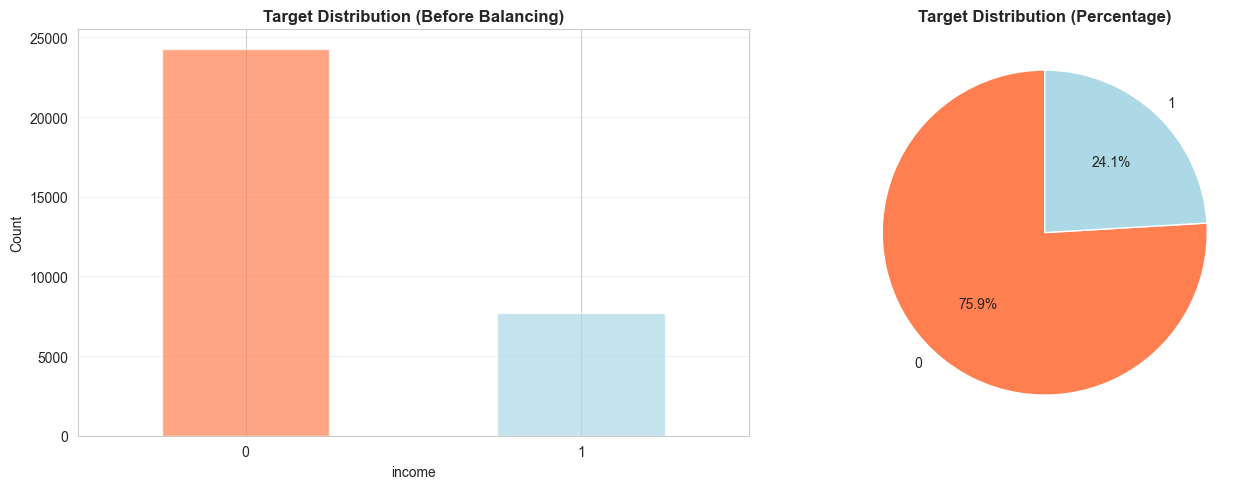

In [11]:
if target_col in df_encoded.columns:
    target_dist = df_encoded[target_col].value_counts()
    
    print("=== Target Variable Distribution (Before Balancing) ===")
    print(target_dist)
    print(f"\nClass balance ratio: {(target_dist.min() / target_dist.max() * 100):.2f}%")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    target_dist.plot(kind='bar', ax=axes[0], color=['coral', 'lightblue'], alpha=0.7)
    axes[0].set_title('Target Distribution (Before Balancing)', fontweight='bold')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=0)
    
    target_dist.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                    colors=['coral', 'lightblue'], startangle=90)
    axes[1].set_title('Target Distribution (Percentage)', fontweight='bold')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/03_target_before_balancing.png', dpi=300, bbox_inches='tight')
    plt.show()

### 6.2 使用SMOTE进行平衡采样

SMOTE (Synthetic Minority Over-sampling Technique) 通过生成合成样本来平衡数据集。

=== Applying SMOTE for Class Balancing ===

Original dataset shape: (31978, 22)
Balanced dataset shape: (48566, 22)

Balanced class distribution:
income
0    24283
1    24283
Name: count, dtype: int64
Class balance ratio: 100.00%


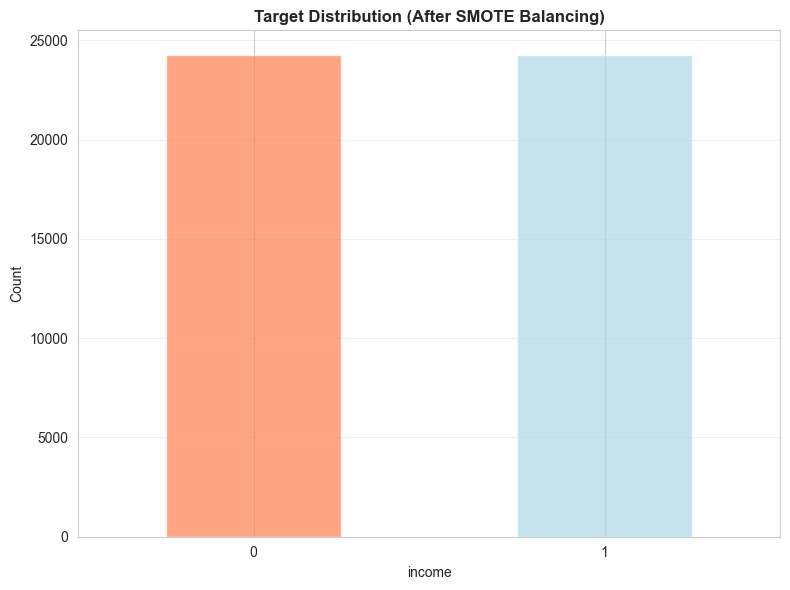

In [12]:
if target_col in df_scaled.columns:
    print("=== Applying SMOTE for Class Balancing ===")
    
    X = df_scaled.drop(columns=[target_col])
    y = df_scaled[target_col]
    
    smote = SMOTE(random_state=42, sampling_strategy='auto')
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
    df_balanced[target_col] = y_balanced
    
    print(f"\nOriginal dataset shape: {df_scaled.shape}")
    print(f"Balanced dataset shape: {df_balanced.shape}")
    
    balanced_dist = df_balanced[target_col].value_counts()
    print(f"\nBalanced class distribution:")
    print(balanced_dist)
    print(f"Class balance ratio: {(balanced_dist.min() / balanced_dist.max() * 100):.2f}%")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    balanced_dist.plot(kind='bar', ax=ax, color=['coral', 'lightblue'], alpha=0.7)
    ax.set_title('Target Distribution (After SMOTE Balancing)', fontweight='bold')
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/03_target_after_balancing.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. 保存处理后的数据

保存三个版本的数据：
1. **Minimal Processing** (实验组A): 仅基本清洗
2. **Full Governance** (实验组B): 完整的数据治理
3. **Balanced** (实验组B变体): 包含平衡采样

In [13]:
print("=== Saving Processed Datasets ===")

df_minimal = df_original.copy()
df_minimal = df_minimal.replace('?', np.nan)
df_minimal = df_minimal.dropna()
df_minimal.to_csv('../data/processed/adult_minimal_processing.csv', index=False)
print(f"✓ Saved minimal processing dataset: {df_minimal.shape}")
print(f"  Path: ../data/processed/adult_minimal_processing.csv")

df_encoded.to_csv('../data/processed/adult_full_governance.csv', index=False)
print(f"\n✓ Saved full governance dataset: {df_encoded.shape}")
print(f"  Path: ../data/processed/adult_full_governance.csv")

df_scaled.to_csv('../data/processed/adult_scaled.csv', index=False)
print(f"\n✓ Saved scaled dataset: {df_scaled.shape}")
print(f"  Path: ../data/processed/adult_scaled.csv")

if target_col in df_balanced.columns:
    df_balanced.to_csv('../data/processed/adult_balanced.csv', index=False)
    print(f"\n✓ Saved balanced dataset: {df_balanced.shape}")
    print(f"  Path: ../data/processed/adult_balanced.csv")

import pickle
with open('../data/processed/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("\n✓ Saved label encoders")

with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Saved scaler")

=== Saving Processed Datasets ===
✓ Saved minimal processing dataset: (30162, 15)
  Path: ../data/processed/adult_minimal_processing.csv

✓ Saved full governance dataset: (31978, 22)
  Path: ../data/processed/adult_full_governance.csv

✓ Saved scaled dataset: (31978, 22)
  Path: ../data/processed/adult_scaled.csv

✓ Saved balanced dataset: (48566, 22)
  Path: ../data/processed/adult_balanced.csv

✓ Saved label encoders
✓ Saved scaler


## 8. 数据治理总结报告

In [14]:
print("="*80)
print("DATA GOVERNANCE SUMMARY REPORT")
print("="*80)

print("\n1. DATA CLEANING")
print(f"   - Original dataset: {df_original.shape}")
print(f"   - After missing value handling: {df.shape}")
print(f"   - Rows removed: {len(df_original) - len(df)}")

print("\n2. OUTLIER HANDLING")
total_outliers = outlier_df['Outliers_Found'].sum()
print(f"   - Total outliers detected: {total_outliers}")
print(f"   - Strategy: Winsorization (capping)")

print("\n3. FEATURE ENGINEERING")
new_features = ['age_squared', 'capital_net', 'has_capital_gain', 'has_capital_loss',
                'is_full_time', 'age_education_interaction', 'is_married']
created_features = [f for f in new_features if f in df.columns]
print(f"   - New features created: {len(created_features)}")
print(f"   - Features: {', '.join(created_features)}")

print("\n4. ENCODING & STANDARDIZATION")
print(f"   - Categorical features encoded: {len(label_encoders)}")
print(f"   - Features standardized: {len(features_to_scale)}")

print("\n5. CLASS BALANCING")
if target_col in df_balanced.columns:
    print(f"   - Original class ratio: {(target_dist.min() / target_dist.max() * 100):.2f}%")
    print(f"   - Balanced class ratio: {(balanced_dist.min() / balanced_dist.max() * 100):.2f}%")
    print(f"   - Samples added via SMOTE: {len(df_balanced) - len(df_scaled)}")

print("\n6. OUTPUT DATASETS")
print(f"   - Minimal Processing: {df_minimal.shape}")
print(f"   - Full Governance: {df_encoded.shape}")
print(f"   - Scaled: {df_scaled.shape}")
if target_col in df_balanced.columns:
    print(f"   - Balanced: {df_balanced.shape}")

print("\n7. ETHICAL CONSIDERATIONS")
print("   ✓ Applied SMOTE to address class imbalance")
print("   ✓ Preserved all demographic information for fairness evaluation")
print("   ✓ Documented all transformations for reproducibility")
print("   ! Note: Gender and racial biases still present in data")
print("   ! Recommendation: Evaluate model fairness metrics in next stage")

print("\n" + "="*80)
print("Data Governance Complete - Ready for Model Training")
print("="*80)

DATA GOVERNANCE SUMMARY REPORT

1. DATA CLEANING
   - Original dataset: (32561, 15)
   - After missing value handling: (31978, 22)
   - Rows removed: 583

2. OUTLIER HANDLING
   - Total outliers detected: 15250
   - Strategy: Winsorization (capping)

3. FEATURE ENGINEERING
   - New features created: 7
   - Features: age_squared, capital_net, has_capital_gain, has_capital_loss, is_full_time, age_education_interaction, is_married

4. ENCODING & STANDARDIZATION
   - Categorical features encoded: 9
   - Features standardized: 21

5. CLASS BALANCING
   - Original class ratio: 31.69%
   - Balanced class ratio: 100.00%
   - Samples added via SMOTE: 16588

6. OUTPUT DATASETS
   - Minimal Processing: (30162, 15)
   - Full Governance: (31978, 22)
   - Scaled: (31978, 22)
   - Balanced: (48566, 22)

7. ETHICAL CONSIDERATIONS
   ✓ Applied SMOTE to address class imbalance
   ✓ Preserved all demographic information for fairness evaluation
   ✓ Documented all transformations for reproducibility
   ! 